In [6]:
%load_ext autoreload
%autoreload 
import Bayes_fun as bf
import utils as util
import Overlord
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#get default parameters, can add your own before or after!
param = util.get_default_param()

#Give the paths to the KS directories for each session
#If you dint have a dir with channel_positions.npy etc look at the detailed example for supplting paths seperatley 
KSdirs = [r'path/to/KSdir/Session1', r'Path/to/KSdir/Session2']
WavePaths, UnitLabelPaths, ChannelPos = util.paths_fromKS(KSdirs)

In [5]:

#read in data and select the good units and exact metadata
waveform, SessionID, SessionSwitch, WithinSession, GoodUnits, param = util.load_good_waveforms(WavePaths, UnitLabelPaths, param) # 1-step version of above

# create clusInfo, contains all unit id/session related info
ClusInfo = {'GoodUnits' : GoodUnits, 'SessionSwitch' : SessionSwitch, 'SessionID' : SessionID, 
            'OriginalID' : np.concatenate(GoodUnits) }

#Extract parameters from waveform
ExtractedWaveProperties = Overlord.extract_parameters(waveform, ChannelPos, ClusInfo, param)

#Extract metric scores
TotalScore, CandidatePairs, Scores2Include, Predictors  = Overlord.extract_metric_scores(ExtractedWaveProperties, SessionSwitch, WithinSession, param, niter  = 2)

#Probability analysis
priorMatch = 1 - (param['nExpectedMatches'] / param['nUnits']**2 ) # fredom of choid in prior prob?
Priors = np.array((priorMatch, 1-priorMatch))

labels = CandidatePairs.astype(int)
Cond = np.unique(labels)
ScoreVector = param['ScoreVector']
ParameterKernels = np.full((len(ScoreVector), len(Scores2Include), len(Cond)), np.nan)

ParameterKernels = bf.get_ParameterKernels(Scores2Include, labels, Cond, param, addone = 1)

Probability = bf.apply_naive_bayes(ParameterKernels, Priors, Predictors, param, Cond)

Output = Probability[:,1].reshape(param['nUnits'],param['nUnits'])

c:\Users\Experiment\Documents\temp\UnitMatch\UMPy\Metrics_fun.py:219: RuntimeWarning: invalid value encountered in divide
  ang = np.abs( x1[dimid1,:,:,:,:] - x2[dimid1,:,:,:,:]) / np.abs(x1[dimid2,:,:,:,:] - x2[dimid2,:,:,:,:])


Done drift correction per shank for session pair 1 and 2
Session pair 2/3 has [31  9 28 33] matches per shank, which is below threshold to do per shank drift correction


The percentage of units matched to themselves is: 95.57739557739558%
The percentage of false -ve's then is: 4.422604422604422% 

The rate of miss-match(es) per expected match 0.09950859950859951
The percentage of false +ve's is 0.027270602290730594% for session 1
The percentage of false +ve's is 0.03442103813851025% for session 2
The percentage of false +ve's is 0.04965243296921549% for session 3

This assumes that the spike sorter has made no mistakes


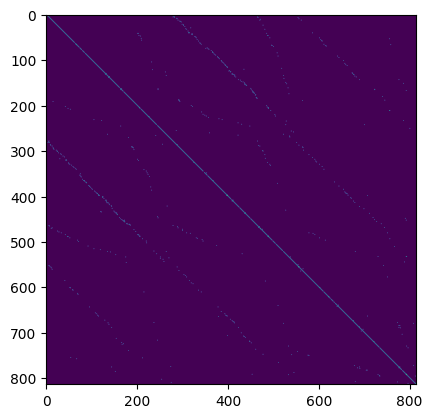

In [5]:
util.evaluate_output(Output, param, WithinSession, SessionSwitch, MatchThreshold = 0.75)

MatchThreshold = 0.5
OutputThreshold = np.zeros_like(Output)
OutputThreshold[Output > MatchThreshold] = 1

plt.imshow(OutputThreshold)


In [6]:
from GUI import *

In [7]:
Amplitude = ExtractedWaveProperties['Amplitude']
SpatialDecay = ExtractedWaveProperties['SpatialDecay']
AvgCentroid = ExtractedWaveProperties['AvgCentroid']
AvgWaveform = ExtractedWaveProperties['AvgWaveform']
AvgWaveformPerTP = ExtractedWaveProperties['AvgWaveformPerTP']
WaveIdx = ExtractedWaveProperties['WaveIdx']
MaxSite = ExtractedWaveProperties['MaxSite']
MaxSiteMean = ExtractedWaveProperties['MaxSiteMean']
process_info_for_GUI(Output, MatchThreshold, Scores2Include, TotalScore, Amplitude, SpatialDecay,
                         AvgCentroid, AvgWaveform, AvgWaveformPerTP, WaveIdx, MaxSite, MaxSiteMean, 
                         waveform, WithinSession, ChannelPos, ClusInfo, param)


In [8]:
IsMatch, NotMatch = run_GUI()